In [1]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [3]:
# Download Maestro = Midi Files 
data_dir = pathlib.Path('data/maestro-v3.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
     'maestro-v3.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

In [4]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1276


In [5]:
# Process a Midi file 
sample_file = filenames[1]
print(sample_file)

data/maestro-v3.0.0/2013/ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_2013_wav--2.midi


In [6]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [7]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [8]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [9]:
num_files = 10
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [10]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 40031


In [11]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [12]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [13]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [15]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [16]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [17]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [18]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape, batch_size=batch_size)
x = tf.keras.layers.LSTM(128, activation="sigmoid", stateful=True)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(64, 25, 3)]                0         []                            
                                                                                                  
 lstm (LSTM)                 (64, 128)                    67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (64, 1)                      129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (64, 128)                    16512     ['lstm[0][0]']                
                                                                                              

In [19]:
losses = model.evaluate(train_ds, return_dict=True)
losses

625/625 [==============================] - 6s 6ms/step - loss: 5.7439 - duration_loss: 0.1525 - pitch_loss: 4.8283 - step_loss: 0.7631


{'loss': 5.74391508102417,
 'duration_loss': 0.15251217782497406,
 'pitch_loss': 4.828309059143066,
 'step_loss': 0.7630922794342041}

In [20]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.5,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [21]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [22]:
%%time
epochs = 20

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/20
625/625 [==============================] - 9s 14ms/step - loss: 2.1417 - duration_loss: 0.0748 - pitch_loss: 4.0347 - step_loss: 0.0495
Epoch 2/20
625/625 [==============================] - 8s 13ms/step - loss: 2.0846 - duration_loss: 0.0580 - pitch_loss: 4.0185 - step_loss: 0.0173
Epoch 3/20
625/625 [==============================] - 8s 13ms/step - loss: 2.0795 - duration_loss: 0.0573 - pitch_loss: 4.0106 - step_loss: 0.0170
Epoch 4/20
625/625 [==============================] - 9s 14ms/step - loss: 2.0745 - duration_loss: 0.0573 - pitch_loss: 4.0006 - step_loss: 0.0168
Epoch 5/20
625/625 [==============================] - 9s 14ms/step - loss: 2.0277 - duration_loss: 0.0573 - pitch_loss: 3.9070 - step_loss: 0.0169
Epoch 6/20
625/625 [==============================] - 9s 14ms/step - loss: 1.9767 - duration_loss: 0.0573 - pitch_loss: 3.8050 - step_loss: 0.0168
Epoch 7/20
625/625 [==============================] - 8s 14ms/step - loss: 1.9629 - duration_loss: 0.0569 - pitch_loss

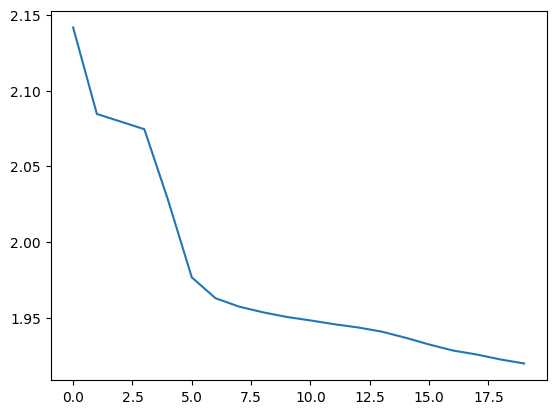

In [23]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [24]:
def custom_predict(notes: np.ndarray, 
    model: tf.keras.Model, 
    temperature: float = 1.0): 
  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  print("Pitch: ")
  print(pitch)
  print("Step: ")
  print(step)
  print("Duration: ")
  print(duration)
  step = tf.maximum(0.0, step)
  duration = tf.maximum(0.0, duration)

  return pitch, step, duration

In [25]:
sample_file = filenames[0]
raw_notes = midi_to_notes(sample_file)

pm = pretty_midi.PrettyMIDI(sample_file)

instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)


model.save("./trainedModel/midi.keras")

INFO:tensorflow:Assets written to: ./trainedModel/assets


INFO:tensorflow:Assets written to: ./trainedModel/assets


In [26]:
temperature = 1.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
pitchT, stepT, durationT = custom_predict(input_notes, model, temperature)
for i in range(len(pitchT)):
  pitch = int(pitchT[i])
  step = float(stepT[i]) * 10
  duration = float(durationT[i]) * 10
  step = tf.maximum(0.0, step)
  duration = tf.maximum(0.0, duration)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 121ms/step
Pitch: 
tf.Tensor(
[74 72 81 75 80 58 86 78 75 56 67 68 64 68 79 65 82 72 40 67 84 53 75 74
 51 80 75 75 84 73 81 53 65 70 77 79 86 66 79 56 77 79 70 67 61 74 77 77
 56 63 80 68 72 63 83 67 77 80 60 73 77 68 76 80], shape=(64,), dtype=int64)
Step: 
tf.Tensor(
[0.03331969 0.03178493 0.03124699 0.03108578 0.03132448 0.03047523
 0.03204524 0.03159672 0.0329363  0.03227307 0.03178732 0.03169717
 0.03120481 0.03085502 0.03165721 0.03407422 0.03151479 0.03118385
 0.0354498  0.03139127 0.03787993 0.03055698 0.03631958 0.03177955
 0.03098446 0.03738541 0.03218526 0.03130326 0.0305789  0.03121829
 0.0309049  0.0323196  0.03013042 0.03578831 0.03066514 0.03204003
 0.03187139 0.03062001 0.03059651 0.03419619 0.03164291 0.03132403
 0.0315252  0.03175769 0.03129385 0.03077293 0.03156773 0.03061302
 0.03324813 0.03280324 0.03163937 0.0315109  0.03207984 0.03049974
 0.03639724 0.03144962 0.03132847 0.03055641 0.03073338 0.03068968
 0.03218209 0.031

In [27]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [28]:
# todo: notwenig? 
#from google.colab import files
#files.download(out_file)

In [29]:
plot_piano_roll(generated_notes)

NameError: name 'plot_piano_roll' is not defined

In [ ]:
plot_distributions(generated_notes)

In [ ]:
# One of the alternatives to using RNNs for music generation is using GANs. 
#Rather than generating audio, a GAN-based approach can generate an entire sequence in parallel. 
# The Magenta team has done impressive work on this approach with GANSynth. 
#You can also find many wonderful music and art projects and open-source code on Magenta project website.